In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

In [3]:
from pathlib import Path

import h5py
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import torch

In [4]:
PATH = Path('../input/shopee-product-matching')
if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')

In [5]:
TAKE_PAIRS = 5

In [6]:
data = pd.read_csv(PATH/'test.csv')


In [7]:
fake_test_df = pd.read_csv(PATH/'train.csv')[['posting_id', 'image', 'image_phash', 'title', 'label_group']]
target_groups = fake_test_df.groupby('label_group').indices
fake_test_df['target']=fake_test_df.label_group.map(target_groups)

data = fake_test_df

In [10]:
def csr_matrix_to_tensor(csr):
    coo = csr.tocoo()
    t = torch.sparse_coo_tensor([coo.row, coo.col], coo.data, csr.shape).cuda()
    return t

def do_chunk_text(embs):
    step = 5000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, embs.shape[0])
        chunk = embs[chunk_start:chunk_end]
        chunk = csr_matrix_to_tensor(chunk).to_dense()
        yield chunk

def generate_text_pairs(data):
    sk_model = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
    text_embeddings =sk_model.fit_transform(data.title)
    sparse_embs = csr_matrix_to_tensor(text_embeddings)
    dists, inds = get_nearest(sparse_embs, do_chunk_text(text_embeddings))
    pairs = sorted_pairs(dists, inds)[:int(len(data)*TAKE_PAIRS)]
    return pairs

In [11]:
pairs = generate_text_pairs(data)

0.661 at 4.9255475997924805 pairs


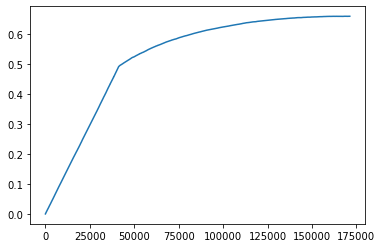

In [12]:
if 'target' in data.columns.to_list():
    _=build_from_pairs(pairs, data.target.to_list())

In [13]:
groups = [[] for _ in range(len(data))]
for x,y,v in pairs:
    groups[x].append(y)

In [14]:
matches = [' '.join(data.iloc[g].posting_id.to_list()) for g in groups]
data['matches'] = matches

In [15]:
data[['posting_id','matches']].to_csv('submission.csv',index=False)

In [16]:
pd.read_csv('submission.csv')

,posting_id,matches
0,train_129225211,train_129225211 train_2278313361
1,train_3386243561,train_3386243561 train_3423213080 train_1831941588 train_3805508898
2,train_2288590299,train_2288590299 train_3803689425
3,train_2406599165,train_2406599165 train_1744956981 train_3526771004 train_3576714541 train_1508100548 train_2043094887 train_2560623727 train_466135735
4,train_3369186413,train_3369186413
...,...,...
34245,train_4028265689,train_4028265689
34246,train_769054909,train_1463059254 train_769054909 train_2530102819 train_2930576726 train_4120437054 train_3668574065 train_538243438 train_1006492702
34247,train_614977732,train_614977732 train_512157627 train_2690464637 train_9568348
34248,train_3630949769,train_3630949769 train_3419392575 train_1431563868
